<a href="https://colab.research.google.com/github/alina0195/sketches/blob/main/Financial_Phrasebank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://huggingface.co/ahmedrachid/FinancialBERT-Sentiment-Analysis

#Connect to drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import data

##Install

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.0 MB/s 
     |████████████████████████████████| 182 kB 69.7 MB/s 
     |████████████████████████████████| 212 kB 70.9 MB/s 
     |████████████████████████████████| 115 kB 58.0 MB/s 
     |████████████████████████████████| 127 kB 69.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


##Read

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset('financial_phrasebank', 'sentences_allagree')

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(dataset)


In [ ]:
df

,train
0,"{'sentence': 'According to Gran , the company ..."
1,"{'sentence': 'For the last quarter of 2010 , C..."
2,"{'sentence': 'In the third quarter of 2010 , n..."
3,{'sentence': 'Operating profit rose to EUR 13....
4,{'sentence': 'Operating profit totalled EUR 21...
...,...
2259,{'sentence': 'Operating result for the 12-mont...
2260,{'sentence': 'HELSINKI Thomson Financial - Sha...
2261,{'sentence': 'LONDON MarketWatch -- Share pric...
2262,{'sentence': 'Operating profit fell to EUR 35....


In [ ]:
train_dict=df.loc[:]['train']

In [ ]:
mylist =[] 
for i in train_dict:
  mylist.append({'text':i['sentence'],'label':i['label']})

In [ ]:
my_df=pd.DataFrame(mylist)

In [ ]:
my_df

,text,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2
...,...,...
2259,Operating result for the 12-month period decre...,0
2260,HELSINKI Thomson Financial - Shares in Cargote...,0
2261,LONDON MarketWatch -- Share prices ended lower...,0
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0


#Pre-process data

##Download packages

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 50.7 MB/s 


In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 4.9 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=a37df4e417b1350911a86f99528cdfb9f3aeef4b438925b516c1b7f504ad9ea0
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


In [ ]:
! pip install Unidecode -q

     |████████████████████████████████| 235 kB 5.2 MB/s 


##Prereq

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from pandas_profiling import ProfileReport


import torch
import torch.nn.functional as F
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup


In [ ]:
import re
import random
import time
import json

In [ ]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer
import html
import unicodedata
import unidecode
import re

###Device

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available():
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
  print("You are running on CPU")

Tesla T4


##Check data

In [ ]:
def dropna_df_for_col(df, target_col):
  df= df.dropna(subset=[target_col])
  df=df.reset_index()
  return df

In [ ]:
def assign_new_label(x):
  if x== 0:
    return 'Negative'
  if x== 1 :
    return 'Neutral'
  else:
    return 'Positive'

In [ ]:
my_df['label'] = my_df['label'].apply(assign_new_label)

In [ ]:
my_df['label'].value_counts()

Neutral     1391
Positive     570
Negative     303
Name: label, dtype: int64

In [ ]:
def plot_distribution(df, target_col, title):
  distribution = df[target_col].value_counts()
  plt.figure(figsize=(8,4))
  plt.bar(distribution.index, distribution.values)
  plt.title(title)
  plt.show()

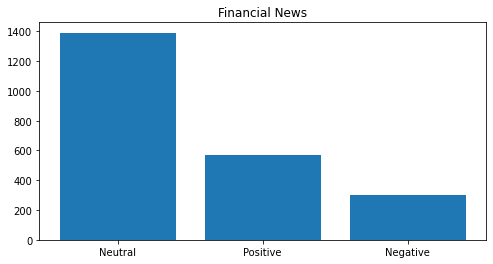

In [ ]:
%matplotlib inline
plot_distribution(my_df,'label','Financial News')

In [ ]:
my_df = dropna_df_for_col(my_df,'label')

In [ ]:
my_df['label'].value_counts()

Neutral     1391
Positive     570
Negative     303
Name: label, dtype: int64

In [ ]:
my_df  = my_df[~my_df.duplicated(subset=['text'])==True]

In [ ]:
my_df['label'].value_counts()

Neutral     1386
Positive     570
Negative     303
Name: label, dtype: int64

## Config Class

In [ ]:
class config:
  SEED = 42
  K_FOLDS = 5
  MODEL_PATH = '/content/drive/MyDrive/models/bertweet_financial.pt'
  MAX_LEN = 512
  PRE_TRAINED_MODEL_NAME = 'ahmedrachid/FinancialBERT' 
  EPOCHS = 20
  LEARNING_RATE = 2e-5
  BATCH_SIZE = 32
  NUM_WORKERS = 2 
  EPS=1e-8
  DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
config.PRE_TRAINED_MODEL_NAME

'ahmedrachid/FinancialBERT'

## Cleaning

In [ ]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()


def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())



print(
    normalizeTweet(
        "SC has first two presumptive cases of coronavirus, DHEC confirms https://postandcourier.com/health/covid19/sc-has-first-two-presumptive-cases-of-coronavirus-dhec-confirms/article_bddfe4ae-5fd3-11ea-9ce4-5f495366cee6.html?utm_medium=social&utm_source=twitter&utm_campaign=user-share… via @postandcourier"
    )
)

SC has first two presumptive cases of coronavirus , DHEC confirms HTTPURL ... via @USER


In [ ]:
my_df['cleaned'] = my_df['text'].apply(normalizeTweet)
my_df

,index,text,label,cleaned
0,0,"According to Gran , the company has no plans t...",Neutral,"According to Gran , the company has no plans t..."
1,1,"For the last quarter of 2010 , Componenta 's n...",Positive,"For the last quarter of 2010 , Componenta ' s ..."
2,2,"In the third quarter of 2010 , net sales incre...",Positive,"In the third quarter of 2010 , net sales incre..."
3,3,Operating profit rose to EUR 13.1 mn from EUR ...,Positive,Operating profit rose to EUR 13.1 mn from EUR ...
4,4,"Operating profit totalled EUR 21.1 mn , up fro...",Positive,"Operating profit totalled EUR 21.1 mn , up fro..."
...,...,...,...,...
2259,2259,Operating result for the 12-month period decre...,Negative,Operating result for the 12 - month period dec...
2260,2260,HELSINKI Thomson Financial - Shares in Cargote...,Negative,HELSINKI Thomson Financial - Shares in Cargote...
2261,2261,LONDON MarketWatch -- Share prices ended lower...,Negative,LONDON MarketWatch - - Share prices ended lowe...
2262,2262,Operating profit fell to EUR 35.4 mn from EUR ...,Negative,Operating profit fell to EUR 35.4 mn from EUR ...


#Import BERT pre-trained model

In [ ]:
bert = AutoModel.from_pretrained(config.PRE_TRAINED_MODEL_NAME)

tokenizer = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at ahmedrachid/FinancialBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ahmedrachid/FinancialBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.

In [ ]:
def tokenize_function(text):
    tok = tokenizer(text,add_special_tokens=True, padding="max_length", max_length = config.MAX_LEN,truncation=True, return_tensors="pt")
    return tok['input_ids'], tok['attention_mask']

In [ ]:
my_df['input_ids'], my_df['attention_mask'] = zip(*my_df['cleaned'].map(tokenize_function))

In [ ]:
my_df

,index,text,label,cleaned,input_ids,attention_mask
0,0,"According to Gran , the company has no plans t...",Neutral,"According to Gran , the company has no plans t...","[[tensor(3), tensor(30797), tensor(16462), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,1,"For the last quarter of 2010 , Componenta 's n...",Positive,"For the last quarter of 2010 , Componenta ' s ...","[[tensor(3), tensor(2), tensor(6), tensor(168)...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,2,"In the third quarter of 2010 , net sales incre...",Positive,"In the third quarter of 2010 , net sales incre...","[[tensor(3), tensor(2), tensor(6), tensor(167)...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,3,Operating profit rose to EUR 13.1 mn from EUR ...,Positive,Operating profit rose to EUR 13.1 mn from EUR ...,"[[tensor(3), tensor(30868), tensor(24770), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,4,"Operating profit totalled EUR 21.1 mn , up fro...",Positive,"Operating profit totalled EUR 21.1 mn , up fro...","[[tensor(3), tensor(30868), tensor(24770), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
...,...,...,...,...,...,...
2259,2259,Operating result for the 12-month period decre...,Negative,Operating result for the 12 - month period dec...,"[[tensor(3), tensor(30868), tensor(24770), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2260,2260,HELSINKI Thomson Financial - Shares in Cargote...,Negative,HELSINKI Thomson Financial - Shares in Cargote...,"[[tensor(3), tensor(2), tensor(2), tensor(2), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2261,2261,LONDON MarketWatch -- Share prices ended lower...,Negative,LONDON MarketWatch - - Share prices ended lowe...,"[[tensor(3), tensor(30846), tensor(30692), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2262,2262,Operating profit fell to EUR 35.4 mn from EUR ...,Negative,Operating profit fell to EUR 35.4 mn from EUR ...,"[[tensor(3), tensor(30868), tensor(24770), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(my_df, test_size=0.2)

In [ ]:
print(len(df_train), len(df_test))

1807 452


# Dataset

In [ ]:
df_train.shape,df_test.shape

((1807, 6), (452, 6))

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train.label.to_list())
y_test = encoder.transform(df_test.label.to_list())

In [ ]:
y_train[1], y_train.shape, y_test.shape

(1, (1807,), (452,))

In [ ]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, df, encoded_y):
        self.df = df
        self.y = encoded_y

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        text = item['cleaned']
        label = self.y[idx]
        return {
            'text': text,
            'input_ids' : torch.tensor(item['input_ids']).to(device),
            'attention_mask' : torch.tensor(item['attention_mask']).to(device),
            'labels' : torch.tensor(label).to(device)
        }

In [ ]:
test_set = NewsDataset(df_test,y_test)
train_set = NewsDataset(df_train, y_train)

In [ ]:
print(len(test_set))
print(test_set[0])

452


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


{'text': 'Finnish cutlery and hand tools maker Fiskars Oyj Abp ( HEL : FISAS ) said today its net profit rose to EUR 24.1 million ( USD 33.6 m ) in the third quarter of 2010 from EUR 17.9 million a year earlier .', 'input_ids': tensor([[    3,     2,  2726,  4735,   387,     8,  2366,  2166,  4462,     2,
         30868,   387,  3291, 30797,  5935,   333,     2,  3108,     2,   765,
           960,  1163,    38,    46,   358,  1851,     9,     2,  1645,    48,
           428,    27,   333, 30739, 30690, 30698,  3060,    48,  1146,  1276,
           765,    10,     6,   167,    47,     7,   453,    23,     2,  1916,
            48,  1431,    27,    11,    62,  1291,    48,     4,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


# Dataloader

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=config.BATCH_SIZE)

In [ ]:
data = next(iter(train_dataloader))
print(data.keys())
print(data['input_ids'].shape)
print(data['labels'].shape)
print(data['attention_mask'].shape)

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])
torch.Size([32, 1, 512])
torch.Size([32])
torch.Size([32, 1, 512])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


#Model

In [ ]:
# Link: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/ 
class NewsClassifier(nn.Module):
    def __init__(self, bertModel, out_feat):
        super().__init__()
        D_in, H, D_out = bertModel.config.hidden_size, 50, out_feat
        self.bert = bertModel
        self.classifier = nn.Sequential(
            nn.Linear(D_in,H),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(H, D_out),
            nn.Softmax(dim=1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask )
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits

In [ ]:
model = NewsClassifier(bert, 3).to(device) 

In [ ]:
model

NewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

# Optimizer & Scheduler

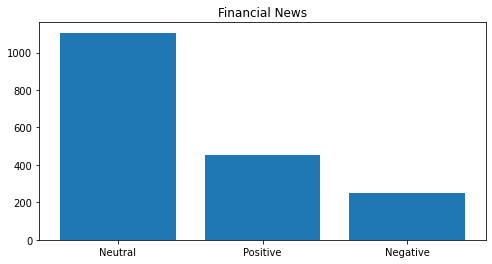

In [ ]:
plot_distribution(df_train,'label','Financial News')

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_weights_train=class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(y_train), y = y_train)
class_weights_train=torch.tensor(class_weights_train,dtype=torch.float)

print('Class Weights for train dataset: ', class_weights_train)

Class Weights for train dataset:  tensor([2.4288, 0.5446, 1.3297])


Class weight penalizes mistakes in samples of class[i] with class_weight[i] instead of 1. So higher class-weight means you want to put more emphasis on a class.

https://androidkt.com/how-to-use-class-weight-in-crossentropyloss-for-an-imbalanced-dataset/

In [ ]:
def init(class_weights):
  optimizer = AdamW(model.parameters(),lr=config.LEARNING_RATE, eps=config.EPS, correct_bias=False, no_deprecation_warning=True)
  total_steps = len(train_dataloader) * config.EPOCHS
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
  loss_fn = nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to(device)

  return optimizer, scheduler,loss_fn

In [ ]:
optimizer, scheduler, loss_fn = init(class_weights_train)